In [656]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import overpass
import requests
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [1138]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [1139]:
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704
421,uNw6t6xk,37.586825,55.794233,-0.002397
422,Ap42ei8k,37.678790,55.772910,-0.910019
423,rn9A8r62,37.752130,55.619640,-0.326547


In [1140]:
test

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.748040,0.0091
1,4LJu4GTf,60.580910,56.795860,0.0091
2,kLuAAN3s,37.598614,55.781357,0.0091
3,OxQHvaNu,37.794051,55.717468,0.0091
4,paQsTa1K,49.213026,55.748290,0.0091
...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091
103,4nmfqUw0,92.928927,56.116262,0.0091
104,N9O45mAh,93.015993,56.023697,0.0091
105,h2InCLKa,30.381172,59.871149,0.0091


In [1141]:
train = pd.concat([train, test])
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.009100
103,4nmfqUw0,92.928927,56.116262,0.009100
104,N9O45mAh,93.015993,56.023697,0.009100
105,h2InCLKa,30.381172,59.871149,0.009100


In [1142]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  relation
    ["place"="city"]
    (area);
  out geom;

  relation
    ["place"="town"]
    (area);
  out geom;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
cities = response.json()

In [352]:
"""
coords = []
for coord in cities['elements'][2]['members'][0]['geometry']:   
    coords.append(Point(coord['lon'], coord['lat']))
coords.append(Point(cities['elements'][2]['members'][0]['geometry'][0]['lon'], 
                    cities['elements'][2]['members'][0]['geometry'][0]['lat']))
pol = []
pol.append(Polygon(coords))
#Polygon(coords)
coords = []
for coord in cities['elements'][2]['members'][1]['geometry']:   
    coords.append(Point(coord['lon'], coord['lat']))
coords.append(Point(cities['elements'][2]['members'][1]['geometry'][0]['lon'], 
                    cities['elements'][2]['members'][1]['geometry'][0]['lat']))
#Polygon(coords)
pol.append(Polygon(coords))


MultiPolygon(pol)
"""

"\ncoords = []\nfor coord in cities['elements'][2]['members'][0]['geometry']:   \n    coords.append(Point(coord['lon'], coord['lat']))\ncoords.append(Point(cities['elements'][2]['members'][0]['geometry'][0]['lon'], \n                    cities['elements'][2]['members'][0]['geometry'][0]['lat']))\npol = []\npol.append(Polygon(coords))\n#Polygon(coords)\ncoords = []\nfor coord in cities['elements'][2]['members'][1]['geometry']:   \n    coords.append(Point(coord['lon'], coord['lat']))\ncoords.append(Point(cities['elements'][2]['members'][1]['geometry'][0]['lon'], \n                    cities['elements'][2]['members'][1]['geometry'][0]['lat']))\n#Polygon(coords)\npol.append(Polygon(coords))\n\n\nMultiPolygon(pol)\n"

In [329]:
"""
from shapely.geometry import Point, Polygon, MultiPolygon

geom = []
for city in cities['elements']:
    if city['type'] == 'relation':
        pol = []
        for member in city['members']:
            if(member['type'] == 'way'):
                coords = []
                for coord in member['geometry']:
                    coords.append(Point(coord['lat'], coord['lon']))
                coords.append(Point(member['geometry'][0]['lat'], member['geometry'][0]['lon']))
                pol.append(Polygon(coords))
        geom.append((MultiPolygon(pol), city['tags']['name'] ))
"""

In [1143]:
from shapely.geometry import Point, Polygon, MultiPolygon

pol = []
for city in cities['elements']:
    if city['type'] == 'relation':
        coords = []
        for member in city['members']:
            if(member['type'] == 'way'):
                for coord in member['geometry']:
                    coords.append(Point(coord['lat'], coord['lon']))
        coords.append(coords[0])
        pol.append((Polygon(coords), city['tags']['name']))
        

In [982]:
"""
main_data = []
for element in cities['elements']:
    if element['type'] == 'relation':
        pol = Polygon(((element['bounds']['minlon'], element['bounds']['minlat']),
                       (element['bounds']['minlon'], element['bounds']['maxlat']),
                       (element['bounds']['maxlon'], element['bounds']['maxlat']),
                       (element['bounds']['maxlon'], element['bounds']['minlat']),
                      (element['bounds']['minlon'], element['bounds']['minlat'])))
        main_data.append((pol, element['tags']['name']))
X = np.array(main_data)
print(X)
"""

"\nmain_data = []\nfor element in cities['elements']:\n    if element['type'] == 'relation':\n        pol = Polygon(((element['bounds']['minlon'], element['bounds']['minlat']),\n                       (element['bounds']['minlon'], element['bounds']['maxlat']),\n                       (element['bounds']['maxlon'], element['bounds']['maxlat']),\n                       (element['bounds']['maxlon'], element['bounds']['minlat']),\n                      (element['bounds']['minlon'], element['bounds']['minlat'])))\n        main_data.append((pol, element['tags']['name']))\nX = np.array(main_data)\nprint(X)\n"

In [1144]:
train['geometry'] = [Point(x,y) for x,y in zip(train.lat, train.lon)]
train = train.drop(['lat', 'lon'], axis = 1)
train

,point_id,target,geometry
0,ommNZCUV,-0.348157,POINT (55.84863000000001 37.590776)
1,nMe2LHPb,1.294206,POINT (55.750271 37.78421)
2,ZgodVRqB,-1.039679,POINT (47.21333 39.635721)
3,0t2jNYdz,-1.169339,POINT (55.78202 37.70457)
4,U27W4QJ7,-0.088837,POINT (55.730188 37.643983)
...,...,...,...
102,y8oQuX5v,0.009100,POINT (60.049792 30.353777)
103,4nmfqUw0,0.009100,POINT (56.116262 92.928927)
104,N9O45mAh,0.009100,POINT (56.023697 93.01599299999999)
105,h2InCLKa,0.009100,POINT (59.871149 30.381172)


In [1145]:
nppol = np.array(pol)
pol_gdf = gpd.GeoDataFrame(nppol)
pol_gdf = pol_gdf.rename(columns={0: 'geometry', 1: 'city'}).set_geometry('geometry')
pol_gdf

,geometry,city
0,"POLYGON ((55.80172 38.40203, 55.80179 38.40208...",Электросталь
1,"POLYGON ((55.98462 37.46799, 55.98368 37.46815...",Долгопрудный
2,"POLYGON ((55.96784 37.26830, 55.96835 37.27006...",Химки
3,"POLYGON ((55.94132 37.81290, 55.93863 37.81221...",Королёв
4,"POLYGON ((59.79371 30.60061, 59.79348 30.60053...",Колпино
...,...,...
168,"POLYGON ((67.48338 63.93882, 67.50997 63.93974...",Воркута
169,"POLYGON ((44.67643 41.90578, 44.67635 41.90675...",Невинномысск
170,"POLYGON ((55.11488 61.55970, 55.11861 61.55942...",Копейск
171,"POLYGON ((53.52219 58.97681, 53.51905 58.97920...",Магнитогорск


In [1146]:
train = gpd.GeoDataFrame(train)
dtrain = gpd.sjoin( pol_gdf, train, how="right", op='contains')
dtrain = dtrain.reset_index(drop = True)
dtrain

,index_left,city,point_id,target,geometry
0,4.0,Колпино,wQOQvE03,-1.126119,POINT (59.73553 30.57983)
1,4.0,Колпино,2kUlAO0h,-1.039679,POINT (59.74039 30.58293)
2,4.0,Колпино,DvEZb53r,-1.212559,POINT (59.74071 30.61053)
3,4.0,Колпино,rkhUhnnc,-0.650698,POINT (59.73877 30.62202)
4,5.0,Пушкин,avEOHzEY,0.127264,POINT (59.72149 30.42787)
...,...,...,...,...,...
527,NaN,NaN,6pVArqoM,-1.212559,POINT (59.90961 29.77714)
528,NaN,NaN,hfO83LAD,0.009100,POINT (56.23348 43.83525)
529,NaN,NaN,ZeaM9y86,0.009100,POINT (54.70603 55.82929)
530,NaN,NaN,Fk1RC0V1,0.009100,POINT (55.97888 37.17152)


In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["place"="city"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
city_centers = response.json()

In [1147]:
centers_lat = []
centers_lon = []
centers_name = []
population = []
for center in city_centers['elements']:
    if center['type'] == 'node':
        centers_lat.append(center['lat'])
        centers_lon.append(center['lon'])
        centers_name.append(center['tags']['name'])
        population.append(center['tags']['population'])
df = pd.DataFrame(
    {'Latitude': centers_lat,
     'Longitude': centers_lon,
     'city': centers_name,
     'population': population})
city_centers_gdf = gpd.GeoDataFrame(
    df.city, geometry= gpd.points_from_xy(df.Latitude, df.Longitude))
city_centers_gdf['population'] = df['population']
city_centers_gdf

,city,geometry,population
0,Новосибирск,POINT (55.028 82.923),1625600
1,Северодвинск,POINT (64.563 39.824),183255
2,Петрозаводск,POINT (61.790 34.390),280170
3,Вологда,POINT (59.219 39.893),311166
4,Тверь,POINT (56.859 35.921),420850
...,...,...,...
369,Салават,POINT (53.362 55.925),153973
370,Бийск,POINT (52.539 85.215),200629
371,Магадан,POINT (59.560 150.799),92782
372,Сызрань,POINT (53.155 48.474),174599


In [1148]:
from geopy import distance

full_city = []
dtrain = dtrain.fillna(0)
for c in range(dtrain['city'].size):
    if dtrain.iloc[c]['city'] == 0:
        minim = 10000000.0
        for c2 in range(city_centers_gdf['city'].size):
            dist = round(distance.geodesic((dtrain.iloc[c]['geometry'].x, dtrain.iloc[c]['geometry'].y),
                (city_centers_gdf.iloc[c2]['geometry'].x, city_centers_gdf.iloc[c2]['geometry'].y)).km, 3)
            if dist < minim:
                minim = dist
                full_city.append(city_centers_gdf.iloc[c2]['city'])
    else:
        full_city.append(dtrain.iloc[c]['city'])
npfc = np.array(full_city)
dtrain['city'] = gpd.GeoDataFrame(npfc)
dtrain

,index_left,city,point_id,target,geometry
0,4.0,Колпино,wQOQvE03,-1.126119,POINT (59.73553 30.57983)
1,4.0,Колпино,2kUlAO0h,-1.039679,POINT (59.74039 30.58293)
2,4.0,Колпино,DvEZb53r,-1.212559,POINT (59.74071 30.61053)
3,4.0,Колпино,rkhUhnnc,-0.650698,POINT (59.73877 30.62202)
4,5.0,Пушкин,avEOHzEY,0.127264,POINT (59.72149 30.42787)
...,...,...,...,...,...
527,0.0,Новосибирск,6pVArqoM,-1.212559,POINT (59.90961 29.77714)
528,0.0,Вологда,hfO83LAD,0.009100,POINT (56.23348 43.83525)
529,0.0,Екатеринбург,ZeaM9y86,0.009100,POINT (54.70603 55.82929)
530,0.0,Новосибирск,Fk1RC0V1,0.009100,POINT (55.97888 37.17152)


In [1149]:
dtrain = dtrain.merge(city_centers_gdf, how = 'left', on='city')
dtrain = dtrain.groupby(by = 'point_id').first()
dtrain = dtrain.rename(columns={'geometry_x': 'geometry', 'geometry_y': 'city_center'}).set_geometry('geometry', 'city_center')
dtrain = dtrain.reset_index()

dist_to_center = []
for c in range(dtrain['geometry'].size):
    dist_to_center.append(round(distance.geodesic((dtrain.iloc[c]['geometry'].x, dtrain.iloc[c]['geometry'].y), 
                                  (dtrain.iloc[c]['city_center'].x, dtrain.iloc[c]['city_center'].y)).km, 3))

dtrain['dist to center'] = dist_to_center
dtrain = dtrain.drop(['city_center'], axis=1)
dtrain

,point_id,index_left,city,target,population,geometry,dist to center
0,09nncz2H,92.0,Москва,0.009100,12630289,POINT (55.79459 37.49205),9.281
1,0BYKB88d,6.0,Новосибирск,-0.391377,1625600,POINT (54.98404 82.89095),5.340
2,0dALVmD0,111.0,Самара,0.009100,1156644,POINT (53.20738 50.19788),5.690
3,0eSE1PRt,92.0,Москва,-0.304937,12630289,POINT (55.68374 37.49105),10.877
4,0t2jNYdz,92.0,Москва,-1.169339,12630289,POINT (55.78202 37.70457),6.499
...,...,...,...,...,...,...,...
527,zq24zBHA,6.0,Новосибирск,0.127264,1625600,POINT (55.03455 82.89944),1.689
528,zqxBvgo3,92.0,Москва,0.473024,12630289,POINT (55.68966 37.60242),6.834
529,zrqrRf0q,36.0,Уфа,-0.650698,1110976,POINT (54.71807 55.98667),2.679
530,zynEGrYK,6.0,Новосибирск,1.294206,1625600,POINT (55.05965 82.91410),3.550


In [1150]:
from functools import partial
import pyproj
from shapely.ops import transform

wgs84_globe = pyproj.Proj(proj='longlat', ellps='WGS84')
def pol_buff_on_globe(_lat, _lon, km):
    aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84',
                       lat_0=_lat, lon_0=_lon)
    buf = Point(0, 0).buffer(km * 1000)
    return transform( partial(pyproj.transform, aeqd, wgs84_globe),
                          buf)




In [1151]:
geodesic_buffers1 = gpd.GeoDataFrame()
geodesic_buffers1['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 1), axis=1)

geodesic_buffers3 = gpd.GeoDataFrame()
geodesic_buffers3['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 3), axis=1)

geodesic_buffers5 = gpd.GeoDataFrame()
geodesic_buffers5['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 5), axis=1)

In [413]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["railway"="station"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
stations = response.json()

In [1152]:
station_lat = []
station_lon = []
for station in stations['elements']:
    if station['type'] == 'node':
        station_lat.append(station['lat'])
        station_lon.append(station['lon'])
#npstation = np.array(station_points)
df = pd.DataFrame(
    {'Latitude': station_lat,
     'Longitude': station_lon})
station_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude,  df.Latitude))
station_gdf

,geometry
0,POINT (33.71117 60.74938)
1,POINT (33.31425 60.62221)
2,POINT (30.35477 59.99046)
3,POINT (30.42501 59.98820)
4,POINT (34.25039 61.94111)
...,...
12715,POINT (123.61851 55.43019)
12716,POINT (123.94023 55.33259)
12717,POINT (93.37648 54.29532)
12718,POINT (37.26606 55.60996)


In [1153]:
buffer_stations1 = gpd.sjoin(geodesic_buffers1, station_gdf, how="left", op='contains')
buffer_stations1 = buffer_stations1.groupby(level=0).index_right.count()
buffer_stations3 = gpd.sjoin(geodesic_buffers3, station_gdf, how="left", op='contains')
buffer_stations3 = buffer_stations3.groupby(level=0).index_right.count()
buffer_stations5 = gpd.sjoin(geodesic_buffers5, station_gdf, how="left", op='contains')
buffer_stations5 = buffer_stations5.groupby(level=0).index_right.count()

In [1154]:
dtrain['Station on 1 km'] = buffer_stations1
#dtrain = dtrain.drop(['index_left'], axis=1)
dtrain['Station on 3 km'] = buffer_stations3
dtrain['Station on 5 km'] = buffer_stations5
dtrain

,point_id,index_left,city,target,population,geometry,dist to center,Station on 1 km,Station on 3 km,Station on 5 km
0,09nncz2H,92.0,Москва,0.009100,12630289,POINT (55.79459 37.49205),9.281,4,24,42
1,0BYKB88d,6.0,Новосибирск,-0.391377,1625600,POINT (54.98404 82.89095),5.340,4,10,18
2,0dALVmD0,111.0,Самара,0.009100,1156644,POINT (53.20738 50.19788),5.690,2,10,22
3,0eSE1PRt,92.0,Москва,-0.304937,12630289,POINT (55.68374 37.49105),10.877,2,12,26
4,0t2jNYdz,92.0,Москва,-1.169339,12630289,POINT (55.78202 37.70457),6.499,2,20,80
...,...,...,...,...,...,...,...,...,...,...
527,zq24zBHA,6.0,Новосибирск,0.127264,1625600,POINT (55.03455 82.89944),1.689,6,30,50
528,zqxBvgo3,92.0,Москва,0.473024,12630289,POINT (55.68966 37.60242),6.834,2,22,62
529,zrqrRf0q,36.0,Уфа,-0.650698,1110976,POINT (54.71807 55.98667),2.679,0,0,2
530,zynEGrYK,6.0,Новосибирск,1.294206,1625600,POINT (55.05965 82.91410),3.550,6,26,46


In [620]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["tourism"="hotel"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
hotels = response.json()

In [1155]:
hotels_lat = []
hotels_lon = []
for hotel in hotels['elements']:
    if hotel['type'] == 'node':
        hotels_lat.append(hotel['lat'])
        hotels_lon.append(hotel['lon'])
df = pd.DataFrame(
    {'Latitude': hotels_lat,
     'Longitude': hotels_lon})
hotels_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude, df.Latitude))

geodesic_buffers5 = gpd.GeoDataFrame()
geodesic_buffers5['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 5), axis=1)

geodesic_buffers2 = gpd.GeoDataFrame()
geodesic_buffers2['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 2), axis=1)

In [1156]:
buffer_hotels2 = gpd.sjoin(geodesic_buffers2, hotels_gdf, how="left", op='contains')
buffer_hotels2 = buffer_hotels2.groupby(level=0).index_right.count()
buffer_hotels5 = gpd.sjoin(geodesic_buffers5, hotels_gdf, how="left", op='contains')
buffer_hotels5 = buffer_hotels5.groupby(level=0).index_right.count()
dtrain['Hotels on 2 km'] = buffer_hotels2
dtrain['Hotels on 5 km'] = buffer_hotels5
dtrain

,point_id,index_left,city,target,population,geometry,dist to center,Station on 1 km,Station on 3 km,Station on 5 km,Hotels on 2 km,Hotels on 5 km
0,09nncz2H,92.0,Москва,0.009100,12630289,POINT (55.79459 37.49205),9.281,4,24,42,6,50
1,0BYKB88d,6.0,Новосибирск,-0.391377,1625600,POINT (54.98404 82.89095),5.340,4,10,18,2,2
2,0dALVmD0,111.0,Самара,0.009100,1156644,POINT (53.20738 50.19788),5.690,2,10,22,12,44
3,0eSE1PRt,92.0,Москва,-0.304937,12630289,POINT (55.68374 37.49105),10.877,2,12,26,2,14
4,0t2jNYdz,92.0,Москва,-1.169339,12630289,POINT (55.78202 37.70457),6.499,2,20,80,30,198
...,...,...,...,...,...,...,...,...,...,...,...,...
527,zq24zBHA,6.0,Новосибирск,0.127264,1625600,POINT (55.03455 82.89944),1.689,6,30,50,14,24
528,zqxBvgo3,92.0,Москва,0.473024,12630289,POINT (55.68966 37.60242),6.834,2,22,62,16,92
529,zrqrRf0q,36.0,Уфа,-0.650698,1110976,POINT (54.71807 55.98667),2.679,0,0,2,4,22
530,zynEGrYK,6.0,Новосибирск,1.294206,1625600,POINT (55.05965 82.91410),3.550,6,26,46,2,36


In [830]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["amenity"="marketplace"]
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
markets = response.json()

In [1157]:
market_lat = []
market_lon = []
for market in markets['elements']:
    if market['type'] == 'node':
        market_lat.append(market['lat'])
        market_lon.append(market['lon'])
df = pd.DataFrame(
    {'Latitude': market_lat,
     'Longitude': market_lon})
hotels_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude, df.Latitude))

geodesic_buffers_market1 = gpd.GeoDataFrame()
geodesic_buffers_market1['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 1), axis=1)

geodesic_buffers_market2 = gpd.GeoDataFrame()
geodesic_buffers_market2['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 2), axis=1)

In [1158]:
buffer_market1 = gpd.sjoin(geodesic_buffers_market1, hotels_gdf, how="left", op='contains')
buffer_market1 = buffer_market1.groupby(level=0).index_right.count()
buffer_market2 = gpd.sjoin(geodesic_buffers_market2, hotels_gdf, how="left", op='contains')
buffer_market2 = buffer_market2.groupby(level=0).index_right.count()
dtrain['Markets on 1 km'] = buffer_market1
dtrain['Markets on 2 km'] = buffer_market2
dtrain

,point_id,index_left,city,target,population,geometry,dist to center,Station on 1 km,Station on 3 km,Station on 5 km,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,09nncz2H,92.0,Москва,0.009100,12630289,POINT (55.79459 37.49205),9.281,4,24,42,6,50,0,0
1,0BYKB88d,6.0,Новосибирск,-0.391377,1625600,POINT (54.98404 82.89095),5.340,4,10,18,2,2,0,0
2,0dALVmD0,111.0,Самара,0.009100,1156644,POINT (53.20738 50.19788),5.690,2,10,22,12,44,0,0
3,0eSE1PRt,92.0,Москва,-0.304937,12630289,POINT (55.68374 37.49105),10.877,2,12,26,2,14,0,0
4,0t2jNYdz,92.0,Москва,-1.169339,12630289,POINT (55.78202 37.70457),6.499,2,20,80,30,198,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,zq24zBHA,6.0,Новосибирск,0.127264,1625600,POINT (55.03455 82.89944),1.689,6,30,50,14,24,2,2
528,zqxBvgo3,92.0,Москва,0.473024,12630289,POINT (55.68966 37.60242),6.834,2,22,62,16,92,0,2
529,zrqrRf0q,36.0,Уфа,-0.650698,1110976,POINT (54.71807 55.98667),2.679,0,0,2,4,22,0,2
530,zynEGrYK,6.0,Новосибирск,1.294206,1625600,POINT (55.05965 82.91410),3.550,6,26,46,2,36,0,0


In [1159]:
ytrain = dtrain.target
df_geometry = dtrain.geometry
df_city = dtrain.city

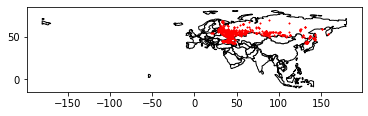

In [1047]:
df_lat = []
df_lon = []
for i in df_geometry:
    df_lat.append(i.x)
    df_lon.append(i.y)
df_map = pd.DataFrame(
    {'City': df_city,
     'Longitude': df_lon,
     'Latitude': df_lat})

gdf_map = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

europe = world[world.continent == 'Europe']
asia = world[world.continent == 'Asia']
eurasia = europe.append(asia)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = eurasia.plot(
    color='white', edgecolor='black')
gdf_map.plot(ax=ax, color='red', markersize = 0.5)
plt.show()

In [955]:
from keplergl import KeplerGl
kg_map = KeplerGl(height = 500)
#kg_map.add_data(gdf_map)
kg_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=500)

In [1048]:
mapa = folium.Map([-15.783333, -47.866667],
                  zoom_start=4,
                  tiles='cartodbpositron')

points = folium.features.GeoJson(gdf_map.to_json())

mapa.add_children(points)
mapa

### Fit model

In [849]:
#X_train, X_valid, y_train, y_valid = train_test_split(dtrain.drop('target', axis=1), dtrain[['target']])
#model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [850]:
#mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6958944500753261

In [1160]:
test['geometry'] = [Point(x,y) for x,y in zip(test.lat, test.lon)]
test = test.drop(['lat', 'lon'], axis = 1)
test

,point_id,target,geometry
0,F4lXR1cG,0.0091,POINT (55.74804 37.681242)
1,4LJu4GTf,0.0091,POINT (56.79586 60.58091)
2,kLuAAN3s,0.0091,POINT (55.78135699999999 37.59861400000001)
3,OxQHvaNu,0.0091,POINT (55.717468 37.794051)
4,paQsTa1K,0.0091,POINT (55.74829 49.213026)
...,...,...,...
102,y8oQuX5v,0.0091,POINT (60.049792 30.353777)
103,4nmfqUw0,0.0091,POINT (56.116262 92.928927)
104,N9O45mAh,0.0091,POINT (56.023697 93.01599299999999)
105,h2InCLKa,0.0091,POINT (59.871149 30.381172)


In [1161]:
dtrain = dtrain.drop(['index_left'], axis=1)

In [1162]:
test = gpd.GeoDataFrame(test).set_geometry('geometry')
sample = gpd.sjoin(test, dtrain, how="left", op='contains')
sample

,point_id_left,target_left,geometry,index_right,point_id_right,city,target_right,population,dist to center,Station on 1 km,Station on 3 km,Station on 5 km,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,F4lXR1cG,0.0091,POINT (55.748 37.681),134,F4lXR1cG,Москва,0.0091,12630289,4.012,6,34,148,40,424,2,2
1,4LJu4GTf,0.0091,POINT (56.796 60.581),34,4LJu4GTf,Екатеринбург,0.0091,1468833,5.097,0,2,12,2,88,0,2
2,kLuAAN3s,0.0091,POINT (55.781 37.599),390,kLuAAN3s,Москва,0.0091,12630289,3.640,4,60,140,110,480,0,0
3,OxQHvaNu,0.0091,POINT (55.717 37.794),208,OxQHvaNu,Москва,0.0091,12630289,11.683,4,16,40,6,48,2,4
4,paQsTa1K,0.0091,POINT (55.748 49.213),441,paQsTa1K,Казань,0.0091,1251969,6.742,4,6,8,6,18,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,y8oQuX5v,0.0091,POINT (60.050 30.354),514,y8oQuX5v,Санкт-Петербург,0.0091,5381736,12.550,0,6,24,10,24,0,0
103,4nmfqUw0,0.0091,POINT (56.116 92.929),39,4nmfqUw0,Красноярск,0.0091,1095286,12.439,0,0,4,0,0,0,2
104,N9O45mAh,0.0091,POINT (56.024 93.016),193,N9O45mAh,Красноярск,0.0091,1095286,9.095,0,0,4,4,10,0,0
105,h2InCLKa,0.0091,POINT (59.871 30.381),362,h2InCLKa,Санкт-Петербург,0.0091,5381736,8.361,2,14,42,10,72,0,0


In [1134]:
dtrain

,point_id,city,target,population,geometry,dist to center,Station on 1 km,Station on 3 km,Station on 5 km,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,09nncz2H,Москва,0.009100,12630289,POINT (55.79459 37.49205),9.281,4,24,42,6,50,0,0
1,0BYKB88d,Новосибирск,-0.391377,1625600,POINT (54.98404 82.89095),5.340,4,10,18,2,2,0,0
2,0dALVmD0,Самара,0.009100,1156644,POINT (53.20738 50.19788),5.690,2,10,22,12,44,0,0
3,0eSE1PRt,Москва,-0.304937,12630289,POINT (55.68374 37.49105),10.877,2,12,26,2,14,0,0
4,0t2jNYdz,Москва,-1.169339,12630289,POINT (55.78202 37.70457),6.499,2,20,80,30,198,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,zq24zBHA,Новосибирск,0.127264,1625600,POINT (55.03455 82.89944),1.689,6,30,50,14,24,2,2
528,zqxBvgo3,Москва,0.473024,12630289,POINT (55.68966 37.60242),6.834,2,22,62,16,92,0,2
529,zrqrRf0q,Уфа,-0.650698,1110976,POINT (54.71807 55.98667),2.679,0,0,2,4,22,0,2
530,zynEGrYK,Новосибирск,1.294206,1625600,POINT (55.05965 82.91410),3.550,6,26,46,2,36,0,0


In [1163]:
dtrain = dtrain.drop(['city', 'geometry'], axis=1)

In [1164]:
from catboost import CatBoostRegressor
mae = 0
for i in range(20):
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain.drop('target', axis=1), dtrain[['target']])
    model = CatBoostRegressor(iterations=300, loss_function='MAE').fit(X_train.drop('point_id', axis=1), y_train)
    mae += mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))
print(mae/20)

0:	learn: 0.5421996	total: 2.19ms	remaining: 656ms
1:	learn: 0.5410538	total: 4.12ms	remaining: 614ms
2:	learn: 0.5402559	total: 5.55ms	remaining: 549ms
3:	learn: 0.5397823	total: 6.99ms	remaining: 518ms
4:	learn: 0.5392628	total: 10.5ms	remaining: 618ms
5:	learn: 0.5380925	total: 12.1ms	remaining: 592ms
6:	learn: 0.5369896	total: 14.5ms	remaining: 608ms
7:	learn: 0.5361113	total: 16.2ms	remaining: 590ms
8:	learn: 0.5358417	total: 17.8ms	remaining: 575ms
9:	learn: 0.5352750	total: 19.5ms	remaining: 566ms
10:	learn: 0.5335390	total: 22.8ms	remaining: 599ms
11:	learn: 0.5322118	total: 25.8ms	remaining: 620ms
12:	learn: 0.5314890	total: 27.6ms	remaining: 609ms
13:	learn: 0.5310214	total: 29.4ms	remaining: 602ms
14:	learn: 0.5300004	total: 33.9ms	remaining: 643ms
15:	learn: 0.5290608	total: 35.6ms	remaining: 631ms
16:	learn: 0.5280042	total: 40.6ms	remaining: 675ms
17:	learn: 0.5273039	total: 42.1ms	remaining: 659ms
18:	learn: 0.5264910	total: 43.6ms	remaining: 645ms
19:	learn: 0.5262363	t

236:	learn: 0.4221560	total: 354ms	remaining: 94.1ms
237:	learn: 0.4217360	total: 356ms	remaining: 92.8ms
238:	learn: 0.4207638	total: 358ms	remaining: 91.4ms
239:	learn: 0.4197929	total: 361ms	remaining: 90.1ms
240:	learn: 0.4194788	total: 362ms	remaining: 88.7ms
241:	learn: 0.4191890	total: 364ms	remaining: 87.2ms
242:	learn: 0.4190081	total: 365ms	remaining: 85.6ms
243:	learn: 0.4188212	total: 367ms	remaining: 84.1ms
244:	learn: 0.4181254	total: 369ms	remaining: 82.9ms
245:	learn: 0.4174839	total: 374ms	remaining: 82.2ms
246:	learn: 0.4170445	total: 377ms	remaining: 81ms
247:	learn: 0.4165742	total: 380ms	remaining: 79.6ms
248:	learn: 0.4163129	total: 381ms	remaining: 78ms
249:	learn: 0.4155557	total: 382ms	remaining: 76.4ms
250:	learn: 0.4148871	total: 383ms	remaining: 74.7ms
251:	learn: 0.4143262	total: 384ms	remaining: 73.2ms
252:	learn: 0.4139777	total: 385ms	remaining: 71.6ms
253:	learn: 0.4136458	total: 387ms	remaining: 70ms
254:	learn: 0.4132570	total: 388ms	remaining: 68.5ms

184:	learn: 0.4410976	total: 232ms	remaining: 144ms
185:	learn: 0.4408240	total: 236ms	remaining: 145ms
186:	learn: 0.4405359	total: 238ms	remaining: 144ms
187:	learn: 0.4403037	total: 241ms	remaining: 143ms
188:	learn: 0.4388605	total: 243ms	remaining: 143ms
189:	learn: 0.4387141	total: 249ms	remaining: 144ms
190:	learn: 0.4381605	total: 252ms	remaining: 144ms
191:	learn: 0.4379534	total: 253ms	remaining: 142ms
192:	learn: 0.4376462	total: 255ms	remaining: 141ms
193:	learn: 0.4369710	total: 256ms	remaining: 140ms
194:	learn: 0.4367139	total: 258ms	remaining: 139ms
195:	learn: 0.4364828	total: 259ms	remaining: 137ms
196:	learn: 0.4358427	total: 260ms	remaining: 136ms
197:	learn: 0.4354633	total: 261ms	remaining: 134ms
198:	learn: 0.4350529	total: 263ms	remaining: 133ms
199:	learn: 0.4346003	total: 264ms	remaining: 132ms
200:	learn: 0.4340457	total: 265ms	remaining: 131ms
201:	learn: 0.4338833	total: 267ms	remaining: 129ms
202:	learn: 0.4337502	total: 268ms	remaining: 128ms
203:	learn: 

158:	learn: 0.4619919	total: 179ms	remaining: 158ms
159:	learn: 0.4617845	total: 181ms	remaining: 159ms
160:	learn: 0.4615424	total: 184ms	remaining: 159ms
161:	learn: 0.4607352	total: 185ms	remaining: 158ms
162:	learn: 0.4597535	total: 187ms	remaining: 157ms
163:	learn: 0.4596144	total: 189ms	remaining: 157ms
164:	learn: 0.4591473	total: 200ms	remaining: 163ms
165:	learn: 0.4590759	total: 201ms	remaining: 162ms
166:	learn: 0.4588167	total: 202ms	remaining: 161ms
167:	learn: 0.4582285	total: 203ms	remaining: 160ms
168:	learn: 0.4572524	total: 204ms	remaining: 158ms
169:	learn: 0.4565652	total: 206ms	remaining: 158ms
170:	learn: 0.4564493	total: 207ms	remaining: 156ms
171:	learn: 0.4558922	total: 208ms	remaining: 155ms
172:	learn: 0.4555196	total: 210ms	remaining: 154ms
173:	learn: 0.4553077	total: 211ms	remaining: 153ms
174:	learn: 0.4551179	total: 213ms	remaining: 152ms
175:	learn: 0.4544685	total: 214ms	remaining: 151ms
176:	learn: 0.4536834	total: 215ms	remaining: 150ms
177:	learn: 

80:	learn: 0.5106059	total: 93ms	remaining: 251ms
81:	learn: 0.5102731	total: 96ms	remaining: 255ms
82:	learn: 0.5099359	total: 97.5ms	remaining: 255ms
83:	learn: 0.5097732	total: 98.5ms	remaining: 253ms
84:	learn: 0.5096933	total: 99.1ms	remaining: 251ms
85:	learn: 0.5091602	total: 101ms	remaining: 250ms
86:	learn: 0.5082969	total: 102ms	remaining: 250ms
87:	learn: 0.5077636	total: 104ms	remaining: 249ms
88:	learn: 0.5076914	total: 104ms	remaining: 248ms
89:	learn: 0.5073319	total: 109ms	remaining: 255ms
90:	learn: 0.5072915	total: 110ms	remaining: 253ms
91:	learn: 0.5071024	total: 111ms	remaining: 252ms
92:	learn: 0.5066166	total: 112ms	remaining: 250ms
93:	learn: 0.5062905	total: 113ms	remaining: 249ms
94:	learn: 0.5055052	total: 115ms	remaining: 247ms
95:	learn: 0.5048911	total: 116ms	remaining: 246ms
96:	learn: 0.5042991	total: 117ms	remaining: 244ms
97:	learn: 0.5039619	total: 118ms	remaining: 242ms
98:	learn: 0.5039420	total: 118ms	remaining: 240ms
99:	learn: 0.5028705	total: 11

47:	learn: 0.5211472	total: 54.2ms	remaining: 284ms
48:	learn: 0.5206045	total: 56.2ms	remaining: 288ms
49:	learn: 0.5200481	total: 58.7ms	remaining: 293ms
50:	learn: 0.5196493	total: 61.7ms	remaining: 301ms
51:	learn: 0.5190523	total: 66.9ms	remaining: 319ms
52:	learn: 0.5189600	total: 69.4ms	remaining: 323ms
53:	learn: 0.5181806	total: 71.1ms	remaining: 324ms
54:	learn: 0.5175981	total: 72.3ms	remaining: 322ms
55:	learn: 0.5173887	total: 73.3ms	remaining: 320ms
56:	learn: 0.5168691	total: 74.4ms	remaining: 317ms
57:	learn: 0.5164901	total: 75.6ms	remaining: 315ms
58:	learn: 0.5156016	total: 76.7ms	remaining: 313ms
59:	learn: 0.5153701	total: 78.3ms	remaining: 313ms
60:	learn: 0.5152019	total: 79.5ms	remaining: 312ms
61:	learn: 0.5142987	total: 80.9ms	remaining: 310ms
62:	learn: 0.5138153	total: 82.3ms	remaining: 309ms
63:	learn: 0.5135534	total: 83.7ms	remaining: 309ms
64:	learn: 0.5131078	total: 85ms	remaining: 307ms
65:	learn: 0.5129238	total: 86.1ms	remaining: 305ms
66:	learn: 0.5

14:	learn: 0.5416586	total: 17.5ms	remaining: 332ms
15:	learn: 0.5410148	total: 19.6ms	remaining: 349ms
16:	learn: 0.5396993	total: 21.1ms	remaining: 352ms
17:	learn: 0.5389572	total: 22.6ms	remaining: 353ms
18:	learn: 0.5379276	total: 25.5ms	remaining: 377ms
19:	learn: 0.5364454	total: 27.2ms	remaining: 381ms
20:	learn: 0.5357638	total: 28.4ms	remaining: 377ms
21:	learn: 0.5350286	total: 29.5ms	remaining: 373ms
22:	learn: 0.5345309	total: 31ms	remaining: 374ms
23:	learn: 0.5335893	total: 32.6ms	remaining: 375ms
24:	learn: 0.5332508	total: 35.5ms	remaining: 390ms
25:	learn: 0.5326771	total: 37.4ms	remaining: 394ms
26:	learn: 0.5316501	total: 38.7ms	remaining: 392ms
27:	learn: 0.5309643	total: 40.1ms	remaining: 390ms
28:	learn: 0.5280882	total: 41.4ms	remaining: 387ms
29:	learn: 0.5270838	total: 42.8ms	remaining: 385ms
30:	learn: 0.5263012	total: 45.2ms	remaining: 392ms
31:	learn: 0.5259494	total: 46.6ms	remaining: 390ms
32:	learn: 0.5256413	total: 48ms	remaining: 388ms
33:	learn: 0.524

267:	learn: 0.4136618	total: 377ms	remaining: 45ms
268:	learn: 0.4133376	total: 398ms	remaining: 45.9ms
269:	learn: 0.4130272	total: 400ms	remaining: 44.4ms
270:	learn: 0.4125729	total: 401ms	remaining: 42.9ms
271:	learn: 0.4120603	total: 402ms	remaining: 41.4ms
272:	learn: 0.4113220	total: 404ms	remaining: 39.9ms
273:	learn: 0.4109969	total: 405ms	remaining: 38.5ms
274:	learn: 0.4107483	total: 407ms	remaining: 37ms
275:	learn: 0.4102381	total: 408ms	remaining: 35.5ms
276:	learn: 0.4099298	total: 409ms	remaining: 34ms
277:	learn: 0.4096518	total: 410ms	remaining: 32.5ms
278:	learn: 0.4092293	total: 412ms	remaining: 31ms
279:	learn: 0.4089081	total: 414ms	remaining: 29.5ms
280:	learn: 0.4086187	total: 415ms	remaining: 28.1ms
281:	learn: 0.4081667	total: 416ms	remaining: 26.6ms
282:	learn: 0.4080201	total: 418ms	remaining: 25.1ms
283:	learn: 0.4077684	total: 420ms	remaining: 23.7ms
284:	learn: 0.4073453	total: 423ms	remaining: 22.3ms
285:	learn: 0.4070373	total: 425ms	remaining: 20.8ms
2

210:	learn: 0.4210147	total: 269ms	remaining: 113ms
211:	learn: 0.4198038	total: 271ms	remaining: 113ms
212:	learn: 0.4188328	total: 275ms	remaining: 112ms
213:	learn: 0.4181130	total: 278ms	remaining: 112ms
214:	learn: 0.4179023	total: 286ms	remaining: 113ms
215:	learn: 0.4171586	total: 291ms	remaining: 113ms
216:	learn: 0.4168900	total: 298ms	remaining: 114ms
217:	learn: 0.4166516	total: 306ms	remaining: 115ms
218:	learn: 0.4163278	total: 308ms	remaining: 114ms
219:	learn: 0.4155032	total: 310ms	remaining: 113ms
220:	learn: 0.4154535	total: 312ms	remaining: 111ms
221:	learn: 0.4152990	total: 313ms	remaining: 110ms
222:	learn: 0.4150573	total: 314ms	remaining: 108ms
223:	learn: 0.4143048	total: 315ms	remaining: 107ms
224:	learn: 0.4139977	total: 319ms	remaining: 106ms
225:	learn: 0.4127445	total: 323ms	remaining: 106ms
226:	learn: 0.4122940	total: 331ms	remaining: 106ms
227:	learn: 0.4111557	total: 333ms	remaining: 105ms
228:	learn: 0.4110411	total: 335ms	remaining: 104ms
229:	learn: 

101:	learn: 0.4774007	total: 369ms	remaining: 717ms
102:	learn: 0.4770979	total: 374ms	remaining: 715ms
103:	learn: 0.4762296	total: 377ms	remaining: 710ms
104:	learn: 0.4761348	total: 384ms	remaining: 713ms
105:	learn: 0.4759402	total: 488ms	remaining: 893ms
106:	learn: 0.4755491	total: 490ms	remaining: 883ms
107:	learn: 0.4749752	total: 491ms	remaining: 873ms
108:	learn: 0.4744412	total: 492ms	remaining: 863ms
109:	learn: 0.4739045	total: 496ms	remaining: 856ms
110:	learn: 0.4734764	total: 527ms	remaining: 897ms
111:	learn: 0.4732583	total: 531ms	remaining: 891ms
112:	learn: 0.4730291	total: 534ms	remaining: 883ms
113:	learn: 0.4720351	total: 536ms	remaining: 875ms
114:	learn: 0.4716228	total: 537ms	remaining: 865ms
115:	learn: 0.4715722	total: 538ms	remaining: 854ms
116:	learn: 0.4711635	total: 540ms	remaining: 844ms
117:	learn: 0.4708665	total: 541ms	remaining: 835ms
118:	learn: 0.4706621	total: 543ms	remaining: 826ms
119:	learn: 0.4702360	total: 545ms	remaining: 817ms
120:	learn: 

0:	learn: 0.5768010	total: 4.02ms	remaining: 1.2s
1:	learn: 0.5760264	total: 5.45ms	remaining: 812ms
2:	learn: 0.5753969	total: 6.89ms	remaining: 683ms
3:	learn: 0.5740828	total: 8.06ms	remaining: 596ms
4:	learn: 0.5734406	total: 9.77ms	remaining: 576ms
5:	learn: 0.5725319	total: 12ms	remaining: 586ms
6:	learn: 0.5714708	total: 13.8ms	remaining: 578ms
7:	learn: 0.5703723	total: 17.1ms	remaining: 624ms
8:	learn: 0.5693715	total: 18.6ms	remaining: 602ms
9:	learn: 0.5681346	total: 20.3ms	remaining: 589ms
10:	learn: 0.5668118	total: 22.1ms	remaining: 581ms
11:	learn: 0.5653026	total: 27.5ms	remaining: 661ms
12:	learn: 0.5645439	total: 29ms	remaining: 640ms
13:	learn: 0.5630047	total: 30.3ms	remaining: 619ms
14:	learn: 0.5615360	total: 31.9ms	remaining: 606ms
15:	learn: 0.5612466	total: 33ms	remaining: 586ms
16:	learn: 0.5598919	total: 34.4ms	remaining: 573ms
17:	learn: 0.5575796	total: 35.8ms	remaining: 561ms
18:	learn: 0.5567471	total: 38ms	remaining: 563ms
19:	learn: 0.5562581	total: 40.

236:	learn: 0.4309616	total: 355ms	remaining: 94.3ms
237:	learn: 0.4306856	total: 356ms	remaining: 92.8ms
238:	learn: 0.4303483	total: 358ms	remaining: 91.4ms
239:	learn: 0.4299802	total: 359ms	remaining: 89.9ms
240:	learn: 0.4287868	total: 362ms	remaining: 88.5ms
241:	learn: 0.4280536	total: 364ms	remaining: 87.3ms
242:	learn: 0.4275154	total: 366ms	remaining: 85.8ms
243:	learn: 0.4265886	total: 369ms	remaining: 84.7ms
244:	learn: 0.4262950	total: 373ms	remaining: 83.7ms
245:	learn: 0.4260123	total: 374ms	remaining: 82.1ms
246:	learn: 0.4256321	total: 375ms	remaining: 80.5ms
247:	learn: 0.4254148	total: 376ms	remaining: 78.9ms
248:	learn: 0.4251305	total: 377ms	remaining: 77.3ms
249:	learn: 0.4247828	total: 379ms	remaining: 75.8ms
250:	learn: 0.4242173	total: 380ms	remaining: 74.2ms
251:	learn: 0.4237564	total: 381ms	remaining: 72.7ms
252:	learn: 0.4232444	total: 383ms	remaining: 71.1ms
253:	learn: 0.4228351	total: 384ms	remaining: 69.5ms
254:	learn: 0.4222569	total: 386ms	remaining: 

133:	learn: 0.4961443	total: 224ms	remaining: 278ms
134:	learn: 0.4959071	total: 228ms	remaining: 279ms
135:	learn: 0.4955346	total: 235ms	remaining: 283ms
136:	learn: 0.4954135	total: 236ms	remaining: 281ms
137:	learn: 0.4949563	total: 238ms	remaining: 279ms
138:	learn: 0.4945485	total: 239ms	remaining: 277ms
139:	learn: 0.4944273	total: 242ms	remaining: 277ms
140:	learn: 0.4940225	total: 244ms	remaining: 276ms
141:	learn: 0.4937242	total: 246ms	remaining: 274ms
142:	learn: 0.4931003	total: 247ms	remaining: 272ms
143:	learn: 0.4927955	total: 249ms	remaining: 270ms
144:	learn: 0.4926406	total: 250ms	remaining: 268ms
145:	learn: 0.4920156	total: 252ms	remaining: 266ms
146:	learn: 0.4917669	total: 253ms	remaining: 263ms
147:	learn: 0.4913647	total: 254ms	remaining: 261ms
148:	learn: 0.4910892	total: 256ms	remaining: 259ms
149:	learn: 0.4906545	total: 257ms	remaining: 257ms
150:	learn: 0.4905992	total: 258ms	remaining: 255ms
151:	learn: 0.4901715	total: 259ms	remaining: 253ms
152:	learn: 

11:	learn: 0.5252505	total: 59.7ms	remaining: 1.43s
12:	learn: 0.5241379	total: 61.7ms	remaining: 1.36s
13:	learn: 0.5228603	total: 74.2ms	remaining: 1.52s
14:	learn: 0.5225074	total: 76.9ms	remaining: 1.46s
15:	learn: 0.5216680	total: 79.1ms	remaining: 1.4s
16:	learn: 0.5194891	total: 87.3ms	remaining: 1.45s
17:	learn: 0.5183287	total: 89.3ms	remaining: 1.4s
18:	learn: 0.5176429	total: 90.6ms	remaining: 1.34s
19:	learn: 0.5171802	total: 101ms	remaining: 1.41s
20:	learn: 0.5158677	total: 107ms	remaining: 1.43s
21:	learn: 0.5157332	total: 116ms	remaining: 1.47s
22:	learn: 0.5153142	total: 119ms	remaining: 1.43s
23:	learn: 0.5143884	total: 121ms	remaining: 1.4s
24:	learn: 0.5139964	total: 123ms	remaining: 1.35s
25:	learn: 0.5127046	total: 124ms	remaining: 1.31s
26:	learn: 0.5122266	total: 126ms	remaining: 1.27s
27:	learn: 0.5114478	total: 129ms	remaining: 1.25s
28:	learn: 0.5105286	total: 132ms	remaining: 1.23s
29:	learn: 0.5100415	total: 133ms	remaining: 1.2s
30:	learn: 0.5094411	total:

186:	learn: 0.4360331	total: 1.17s	remaining: 707ms
187:	learn: 0.4356553	total: 1.17s	remaining: 699ms
188:	learn: 0.4352056	total: 1.17s	remaining: 690ms
189:	learn: 0.4345972	total: 1.2s	remaining: 693ms
190:	learn: 0.4343136	total: 1.2s	remaining: 686ms
191:	learn: 0.4338835	total: 1.21s	remaining: 679ms
192:	learn: 0.4336228	total: 1.23s	remaining: 684ms
193:	learn: 0.4332204	total: 1.24s	remaining: 675ms
194:	learn: 0.4324554	total: 1.24s	remaining: 667ms
195:	learn: 0.4320958	total: 1.24s	remaining: 660ms
196:	learn: 0.4314002	total: 1.25s	remaining: 652ms
197:	learn: 0.4305451	total: 1.26s	remaining: 649ms
198:	learn: 0.4304381	total: 1.26s	remaining: 640ms
199:	learn: 0.4300153	total: 1.26s	remaining: 631ms
200:	learn: 0.4299423	total: 1.26s	remaining: 622ms
201:	learn: 0.4294219	total: 1.26s	remaining: 614ms
202:	learn: 0.4291247	total: 1.27s	remaining: 605ms
203:	learn: 0.4283256	total: 1.27s	remaining: 597ms
204:	learn: 0.4275959	total: 1.29s	remaining: 596ms
205:	learn: 0.

48:	learn: 0.5142290	total: 187ms	remaining: 955ms
49:	learn: 0.5132485	total: 198ms	remaining: 989ms
50:	learn: 0.5128231	total: 216ms	remaining: 1.06s
51:	learn: 0.5113800	total: 222ms	remaining: 1.06s
52:	learn: 0.5111054	total: 223ms	remaining: 1.04s
53:	learn: 0.5103097	total: 226ms	remaining: 1.03s
54:	learn: 0.5092610	total: 232ms	remaining: 1.03s
55:	learn: 0.5086095	total: 238ms	remaining: 1.04s
56:	learn: 0.5081217	total: 239ms	remaining: 1.02s
57:	learn: 0.5076381	total: 241ms	remaining: 1s
58:	learn: 0.5072819	total: 242ms	remaining: 989ms
59:	learn: 0.5069003	total: 243ms	remaining: 974ms
60:	learn: 0.5065904	total: 245ms	remaining: 959ms
61:	learn: 0.5059706	total: 246ms	remaining: 945ms
62:	learn: 0.5051839	total: 249ms	remaining: 936ms
63:	learn: 0.5046090	total: 250ms	remaining: 923ms
64:	learn: 0.5039013	total: 252ms	remaining: 911ms
65:	learn: 0.5036562	total: 253ms	remaining: 898ms
66:	learn: 0.5033734	total: 255ms	remaining: 886ms
67:	learn: 0.5028582	total: 256ms	

0:	learn: 0.5499936	total: 1.07ms	remaining: 319ms
1:	learn: 0.5488324	total: 2.32ms	remaining: 345ms
2:	learn: 0.5481282	total: 3.38ms	remaining: 335ms
3:	learn: 0.5468178	total: 4.43ms	remaining: 328ms
4:	learn: 0.5462493	total: 5.47ms	remaining: 323ms
5:	learn: 0.5447310	total: 6.93ms	remaining: 340ms
6:	learn: 0.5439228	total: 8.45ms	remaining: 354ms
7:	learn: 0.5421944	total: 9.86ms	remaining: 360ms
8:	learn: 0.5408957	total: 11.2ms	remaining: 362ms
9:	learn: 0.5396399	total: 12.4ms	remaining: 360ms
10:	learn: 0.5381145	total: 13.9ms	remaining: 365ms
11:	learn: 0.5364385	total: 15.2ms	remaining: 366ms
12:	learn: 0.5359210	total: 16.4ms	remaining: 362ms
13:	learn: 0.5353049	total: 17.7ms	remaining: 362ms
14:	learn: 0.5347900	total: 19.2ms	remaining: 364ms
15:	learn: 0.5341905	total: 20.5ms	remaining: 364ms
16:	learn: 0.5336175	total: 21.9ms	remaining: 365ms
17:	learn: 0.5328189	total: 23.2ms	remaining: 363ms
18:	learn: 0.5323584	total: 24.5ms	remaining: 362ms
19:	learn: 0.5318084	t

285:	learn: 0.3879704	total: 360ms	remaining: 17.6ms
286:	learn: 0.3874924	total: 362ms	remaining: 16.4ms
287:	learn: 0.3870323	total: 371ms	remaining: 15.5ms
288:	learn: 0.3863168	total: 373ms	remaining: 14.2ms
289:	learn: 0.3861280	total: 374ms	remaining: 12.9ms
290:	learn: 0.3856890	total: 375ms	remaining: 11.6ms
291:	learn: 0.3848770	total: 377ms	remaining: 10.3ms
292:	learn: 0.3846781	total: 379ms	remaining: 9.04ms
293:	learn: 0.3842742	total: 382ms	remaining: 7.79ms
294:	learn: 0.3841489	total: 383ms	remaining: 6.49ms
295:	learn: 0.3835481	total: 384ms	remaining: 5.19ms
296:	learn: 0.3833739	total: 385ms	remaining: 3.89ms
297:	learn: 0.3830690	total: 387ms	remaining: 2.59ms
298:	learn: 0.3828895	total: 388ms	remaining: 1.3ms
299:	learn: 0.3827990	total: 389ms	remaining: 0us
0:	learn: 0.5353237	total: 1.53ms	remaining: 457ms
1:	learn: 0.5340615	total: 3.25ms	remaining: 484ms
2:	learn: 0.5337194	total: 4.71ms	remaining: 466ms
3:	learn: 0.5324856	total: 6ms	remaining: 444ms
4:	learn

220:	learn: 0.4248185	total: 297ms	remaining: 106ms
221:	learn: 0.4242723	total: 299ms	remaining: 105ms
222:	learn: 0.4240454	total: 301ms	remaining: 104ms
223:	learn: 0.4230525	total: 302ms	remaining: 103ms
224:	learn: 0.4224164	total: 304ms	remaining: 101ms
225:	learn: 0.4210273	total: 305ms	remaining: 100ms
226:	learn: 0.4204913	total: 307ms	remaining: 98.7ms
227:	learn: 0.4200410	total: 310ms	remaining: 97.8ms
228:	learn: 0.4197253	total: 313ms	remaining: 96.9ms
229:	learn: 0.4193047	total: 315ms	remaining: 95.8ms
230:	learn: 0.4185986	total: 316ms	remaining: 94.4ms
231:	learn: 0.4180885	total: 317ms	remaining: 92.9ms
232:	learn: 0.4175927	total: 318ms	remaining: 91.5ms
233:	learn: 0.4169392	total: 319ms	remaining: 90ms
234:	learn: 0.4166862	total: 320ms	remaining: 88.6ms
235:	learn: 0.4162548	total: 321ms	remaining: 87.2ms
236:	learn: 0.4155354	total: 323ms	remaining: 85.8ms
237:	learn: 0.4151751	total: 324ms	remaining: 84.4ms
238:	learn: 0.4149693	total: 325ms	remaining: 83ms
239

165:	learn: 0.4343590	total: 235ms	remaining: 190ms
166:	learn: 0.4337289	total: 323ms	remaining: 257ms
167:	learn: 0.4334944	total: 329ms	remaining: 258ms
168:	learn: 0.4331752	total: 330ms	remaining: 256ms
169:	learn: 0.4322192	total: 333ms	remaining: 255ms
170:	learn: 0.4321253	total: 335ms	remaining: 253ms
171:	learn: 0.4317767	total: 344ms	remaining: 256ms
172:	learn: 0.4312883	total: 348ms	remaining: 256ms
173:	learn: 0.4308729	total: 350ms	remaining: 253ms
174:	learn: 0.4306354	total: 351ms	remaining: 251ms
175:	learn: 0.4301781	total: 353ms	remaining: 249ms
176:	learn: 0.4299119	total: 354ms	remaining: 246ms
177:	learn: 0.4298879	total: 355ms	remaining: 244ms
178:	learn: 0.4296020	total: 357ms	remaining: 241ms
179:	learn: 0.4294250	total: 358ms	remaining: 239ms
180:	learn: 0.4285615	total: 360ms	remaining: 236ms
181:	learn: 0.4283933	total: 363ms	remaining: 236ms
182:	learn: 0.4277681	total: 366ms	remaining: 234ms
183:	learn: 0.4274609	total: 373ms	remaining: 235ms
184:	learn: 

34:	learn: 0.5424500	total: 81.5ms	remaining: 617ms
35:	learn: 0.5417680	total: 127ms	remaining: 933ms
36:	learn: 0.5413772	total: 129ms	remaining: 919ms
37:	learn: 0.5409739	total: 131ms	remaining: 901ms
38:	learn: 0.5393188	total: 136ms	remaining: 913ms
39:	learn: 0.5380905	total: 138ms	remaining: 898ms
40:	learn: 0.5378275	total: 142ms	remaining: 898ms
41:	learn: 0.5372234	total: 158ms	remaining: 973ms
42:	learn: 0.5365140	total: 160ms	remaining: 955ms
43:	learn: 0.5357881	total: 161ms	remaining: 938ms
44:	learn: 0.5355213	total: 163ms	remaining: 921ms
45:	learn: 0.5345135	total: 164ms	remaining: 905ms
46:	learn: 0.5341609	total: 166ms	remaining: 895ms
47:	learn: 0.5334962	total: 174ms	remaining: 911ms
48:	learn: 0.5333477	total: 180ms	remaining: 922ms
49:	learn: 0.5325287	total: 184ms	remaining: 921ms
50:	learn: 0.5316990	total: 189ms	remaining: 924ms
51:	learn: 0.5311579	total: 191ms	remaining: 911ms
52:	learn: 0.5308372	total: 192ms	remaining: 896ms
53:	learn: 0.5305899	total: 19

217:	learn: 0.4509172	total: 969ms	remaining: 365ms
218:	learn: 0.4502917	total: 987ms	remaining: 365ms
219:	learn: 0.4501128	total: 996ms	remaining: 362ms
220:	learn: 0.4495438	total: 1.01s	remaining: 361ms
221:	learn: 0.4489791	total: 1.01s	remaining: 357ms
222:	learn: 0.4487145	total: 1.03s	remaining: 357ms
223:	learn: 0.4482094	total: 1.04s	remaining: 353ms
224:	learn: 0.4479141	total: 1.04s	remaining: 347ms
225:	learn: 0.4473598	total: 1.04s	remaining: 342ms
226:	learn: 0.4469145	total: 1.04s	remaining: 336ms
227:	learn: 0.4465814	total: 1.05s	remaining: 331ms
228:	learn: 0.4456187	total: 1.05s	remaining: 325ms
229:	learn: 0.4446567	total: 1.05s	remaining: 319ms
230:	learn: 0.4440832	total: 1.05s	remaining: 314ms
231:	learn: 0.4435516	total: 1.05s	remaining: 308ms
232:	learn: 0.4427856	total: 1.07s	remaining: 308ms
233:	learn: 0.4425838	total: 1.07s	remaining: 302ms
234:	learn: 0.4424079	total: 1.07s	remaining: 297ms
235:	learn: 0.4415229	total: 1.07s	remaining: 291ms
236:	learn: 

141:	learn: 0.4702543	total: 173ms	remaining: 193ms
142:	learn: 0.4701765	total: 177ms	remaining: 194ms
143:	learn: 0.4700903	total: 178ms	remaining: 193ms
144:	learn: 0.4695751	total: 180ms	remaining: 192ms
145:	learn: 0.4694998	total: 181ms	remaining: 191ms
146:	learn: 0.4693825	total: 183ms	remaining: 190ms
147:	learn: 0.4690375	total: 184ms	remaining: 189ms
148:	learn: 0.4685738	total: 186ms	remaining: 188ms
149:	learn: 0.4684299	total: 189ms	remaining: 189ms
150:	learn: 0.4676595	total: 190ms	remaining: 188ms
151:	learn: 0.4671528	total: 192ms	remaining: 187ms
152:	learn: 0.4666074	total: 193ms	remaining: 185ms
153:	learn: 0.4663789	total: 194ms	remaining: 184ms
154:	learn: 0.4657426	total: 195ms	remaining: 182ms
155:	learn: 0.4654215	total: 196ms	remaining: 181ms
156:	learn: 0.4649401	total: 197ms	remaining: 180ms
157:	learn: 0.4645932	total: 198ms	remaining: 178ms
158:	learn: 0.4641228	total: 200ms	remaining: 178ms
159:	learn: 0.4635201	total: 202ms	remaining: 176ms
160:	learn: 

77:	learn: 0.4830869	total: 114ms	remaining: 325ms
78:	learn: 0.4826053	total: 116ms	remaining: 326ms
79:	learn: 0.4822355	total: 118ms	remaining: 324ms
80:	learn: 0.4814831	total: 120ms	remaining: 323ms
81:	learn: 0.4810559	total: 121ms	remaining: 322ms
82:	learn: 0.4807770	total: 126ms	remaining: 331ms
83:	learn: 0.4802260	total: 128ms	remaining: 330ms
84:	learn: 0.4797928	total: 131ms	remaining: 330ms
85:	learn: 0.4790290	total: 132ms	remaining: 328ms
86:	learn: 0.4787742	total: 133ms	remaining: 325ms
87:	learn: 0.4784284	total: 134ms	remaining: 322ms
88:	learn: 0.4782422	total: 135ms	remaining: 320ms
89:	learn: 0.4778725	total: 136ms	remaining: 317ms
90:	learn: 0.4768221	total: 137ms	remaining: 315ms
91:	learn: 0.4764745	total: 138ms	remaining: 312ms
92:	learn: 0.4758045	total: 140ms	remaining: 311ms
93:	learn: 0.4744880	total: 141ms	remaining: 309ms
94:	learn: 0.4740985	total: 142ms	remaining: 307ms
95:	learn: 0.4738367	total: 143ms	remaining: 305ms
96:	learn: 0.4736477	total: 145

297:	learn: 0.3858201	total: 526ms	remaining: 3.53ms
298:	learn: 0.3853237	total: 538ms	remaining: 1.8ms
299:	learn: 0.3849196	total: 541ms	remaining: 0us
0:	learn: 0.5480653	total: 1.49ms	remaining: 446ms
1:	learn: 0.5470325	total: 3.11ms	remaining: 464ms
2:	learn: 0.5465143	total: 4.44ms	remaining: 440ms
3:	learn: 0.5460318	total: 6.05ms	remaining: 448ms
4:	learn: 0.5453220	total: 9.06ms	remaining: 535ms
5:	learn: 0.5442891	total: 128ms	remaining: 6.29s
6:	learn: 0.5434033	total: 130ms	remaining: 5.45s
7:	learn: 0.5424544	total: 135ms	remaining: 4.93s
8:	learn: 0.5418240	total: 143ms	remaining: 4.63s
9:	learn: 0.5404623	total: 145ms	remaining: 4.19s
10:	learn: 0.5398032	total: 146ms	remaining: 3.83s
11:	learn: 0.5387452	total: 147ms	remaining: 3.53s
12:	learn: 0.5381030	total: 149ms	remaining: 3.28s
13:	learn: 0.5373240	total: 150ms	remaining: 3.06s
14:	learn: 0.5364267	total: 151ms	remaining: 2.88s
15:	learn: 0.5351950	total: 153ms	remaining: 2.71s
16:	learn: 0.5337311	total: 154ms	

257:	learn: 0.4163978	total: 953ms	remaining: 155ms
258:	learn: 0.4160044	total: 959ms	remaining: 152ms
259:	learn: 0.4156573	total: 960ms	remaining: 148ms
260:	learn: 0.4151898	total: 962ms	remaining: 144ms
261:	learn: 0.4147184	total: 963ms	remaining: 140ms
262:	learn: 0.4141344	total: 972ms	remaining: 137ms
263:	learn: 0.4139436	total: 979ms	remaining: 134ms
264:	learn: 0.4136320	total: 982ms	remaining: 130ms
265:	learn: 0.4133146	total: 983ms	remaining: 126ms
266:	learn: 0.4129799	total: 984ms	remaining: 122ms
267:	learn: 0.4127922	total: 986ms	remaining: 118ms
268:	learn: 0.4125948	total: 987ms	remaining: 114ms
269:	learn: 0.4121902	total: 988ms	remaining: 110ms
270:	learn: 0.4115368	total: 989ms	remaining: 106ms
271:	learn: 0.4111486	total: 991ms	remaining: 102ms
272:	learn: 0.4108029	total: 992ms	remaining: 98.1ms
273:	learn: 0.4106417	total: 993ms	remaining: 94.2ms
274:	learn: 0.4103538	total: 995ms	remaining: 90.5ms
275:	learn: 0.4095449	total: 996ms	remaining: 86.6ms
276:	lea

122:	learn: 0.4687756	total: 491ms	remaining: 706ms
123:	learn: 0.4684759	total: 521ms	remaining: 740ms
124:	learn: 0.4676554	total: 528ms	remaining: 739ms
125:	learn: 0.4676182	total: 532ms	remaining: 735ms
126:	learn: 0.4675389	total: 535ms	remaining: 729ms
127:	learn: 0.4671805	total: 544ms	remaining: 730ms
128:	learn: 0.4669242	total: 559ms	remaining: 742ms
129:	learn: 0.4651200	total: 571ms	remaining: 746ms
130:	learn: 0.4646752	total: 594ms	remaining: 766ms
131:	learn: 0.4644355	total: 602ms	remaining: 766ms
132:	learn: 0.4640806	total: 604ms	remaining: 758ms
133:	learn: 0.4629017	total: 612ms	remaining: 758ms
134:	learn: 0.4624354	total: 615ms	remaining: 752ms
135:	learn: 0.4617230	total: 644ms	remaining: 777ms
136:	learn: 0.4613177	total: 706ms	remaining: 840ms
137:	learn: 0.4607692	total: 815ms	remaining: 957ms
138:	learn: 0.4597902	total: 1.15s	remaining: 1.33s
139:	learn: 0.4593656	total: 1.15s	remaining: 1.32s
140:	learn: 0.4591852	total: 1.3s	remaining: 1.47s
141:	learn: 0

282:	learn: 0.3894718	total: 1.67s	remaining: 100ms
283:	learn: 0.3887977	total: 1.68s	remaining: 94.4ms
284:	learn: 0.3883152	total: 1.68s	remaining: 88.7ms
285:	learn: 0.3878738	total: 1.69s	remaining: 82.8ms
286:	learn: 0.3874130	total: 1.72s	remaining: 77.9ms
287:	learn: 0.3871063	total: 1.72s	remaining: 71.8ms
288:	learn: 0.3863837	total: 1.73s	remaining: 66ms
289:	learn: 0.3858291	total: 1.75s	remaining: 60.5ms
290:	learn: 0.3855584	total: 1.78s	remaining: 55.1ms
291:	learn: 0.3847050	total: 1.79s	remaining: 49ms
292:	learn: 0.3845360	total: 1.79s	remaining: 42.8ms
293:	learn: 0.3842384	total: 1.79s	remaining: 36.6ms
294:	learn: 0.3831134	total: 1.8s	remaining: 30.4ms
295:	learn: 0.3824732	total: 1.81s	remaining: 24.4ms
296:	learn: 0.3818808	total: 1.81s	remaining: 18.3ms
297:	learn: 0.3815511	total: 1.82s	remaining: 12.2ms
298:	learn: 0.3812678	total: 1.82s	remaining: 6.1ms
299:	learn: 0.3807706	total: 1.83s	remaining: 0us
0.5743217526718813


### Make submission

In [1165]:
sample = sample.drop(['point_id_left', 'geometry', 'target_left', 'index_right', 'point_id_right','city','target_right'], axis = 1)
sample

,population,dist to center,Station on 1 km,Station on 3 km,Station on 5 km,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,12630289,4.012,6,34,148,40,424,2,2
1,1468833,5.097,0,2,12,2,88,0,2
2,12630289,3.640,4,60,140,110,480,0,0
3,12630289,11.683,4,16,40,6,48,2,4
4,1251969,6.742,4,6,8,6,18,0,2
...,...,...,...,...,...,...,...,...,...
102,5381736,12.550,0,6,24,10,24,0,0
103,1095286,12.439,0,0,4,0,0,0,2
104,1095286,9.095,0,0,4,4,10,0,0
105,5381736,8.361,2,14,42,10,72,0,0


In [1166]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(sample)
submission.to_csv('data/my_submission_TashaYa.csv', index=False)